In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [18]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/train.csv")
data = train.append(test,sort=False)
data

<ipython-input-18-4fcc12744c57>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(test,sort=False)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


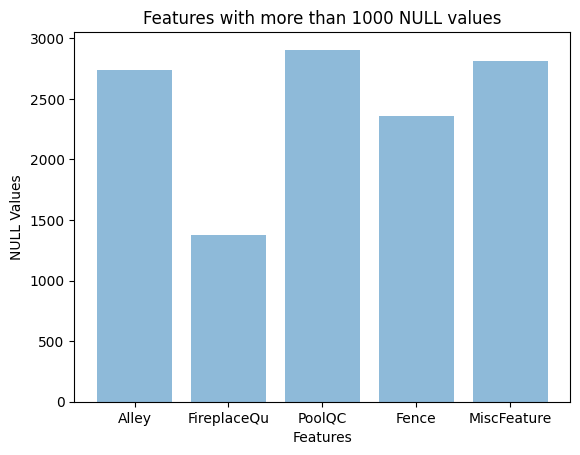

In [19]:
features = []
nullValues = []
for i in data:
    if (data.isna().sum()[i])>1000 and i!='SalePrice':
        features.append(i)
        nullValues.append(data.isna().sum()[i])
y_pos = np.arange(len(features))
plt.bar(y_pos, nullValues, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('NULL Values')
plt.xlabel('Features')
plt.title('Features with more than 1000 NULL values')
plt.show()

In [21]:
data = data.dropna(axis=1, thresh=1000)
data = data.fillna(data.mean())


<ipython-input-21-2e485017e9b1>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


In [22]:
data = pd.get_dummies(data)

In [25]:
covarianceMatrix = data.corr()
listOfFeatures = [i for i in covarianceMatrix]
setOfDroppedFeatures = set()
for i in range(len(listOfFeatures)) :
    for j in range(i+1,len(listOfFeatures)):
        feature1=listOfFeatures[i]
        feature2=listOfFeatures[j]
        if abs(covarianceMatrix[feature1][feature2]) > 0.8:
            setOfDroppedFeatures.add(feature1)
data = data.drop(setOfDroppedFeatures, axis=1)

In [24]:
nonCorrelatedWithOutput = [column for column in data if abs(data[column].corr(data["SalePrice"])) < 0.045]
data = data.drop(nonCorrelatedWithOutput, axis=1)

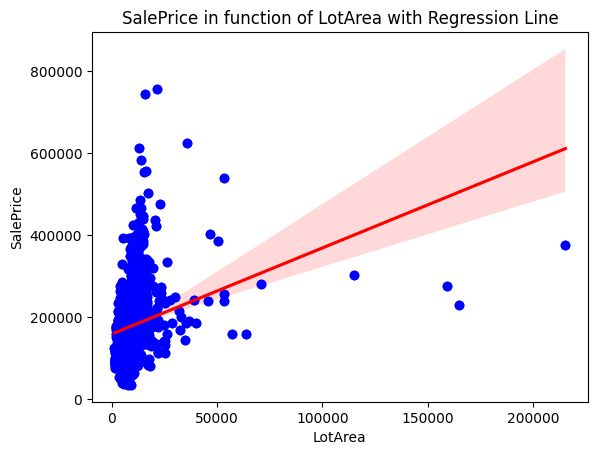

In [26]:
plt.plot(data['LotArea'], data['SalePrice'], 'bo')
sns.regplot(x='LotArea', y='SalePrice', data=data, scatter_kws={'s': 20}, line_kws={'color': 'red'})
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.title('SalePrice in function of LotArea with Regression Line')
plt.show()

In [27]:
newTrain = data.iloc[:1460]
newTest = data.iloc[1460:]
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))
trainWithoutOutliers = newTrain
for column in newTrain:
    outlierValuesList = np.ndarray.tolist(outliers_iqr(newTrain[column])[0])
    trainWithoutOutliers = newTrain.drop(outlierValuesList)

trainWithoutOutliers = newTrain

In [28]:
X = trainWithoutOutliers.drop("SalePrice", axis=1)
Y = np.log1p(trainWithoutOutliers["SalePrice"])
reg = LinearRegression().fit(X, Y)

In [29]:
newTest = newTest.drop("SalePrice", axis=1)
pred = np.expm1(reg.predict(newTest))
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = pred
sub.to_csv("submission.csv", index=False)
sub

,Id,SalePrice
0,1,208203.366964
1,2,204868.142474
2,3,212909.027141
3,4,172503.630910
4,5,310749.553050
...,...,...
1455,1456,177723.212621
1456,1457,208886.267690
1457,1458,270324.615858
1458,1459,150866.081607
